# Load libraries

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import wfdb
from wfdb import processing
from IPython.display import display
from scipy import signal
from scipy.ndimage import label
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

In [34]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

# Find and plot peaks

In [35]:
for record_number in ['05121']:
    #record_number = '06995'
    filepath = 'D:/phd/mit-bih-atrial-fibrillation-database-1.0.0/files/' + record_number
    record = wfdb.rdrecord(filepath)#, sampto = 10000)
    ann = wfdb.rdann(filepath,'atr')
    sig = record.p_signal[:,0]

In [36]:
sig_peaks, _ = signal.find_peaks(sig)
Rpeaks = []
for i in sig_peaks:
    if sig[i] > 0.3:
        Rpeaks.append(i)

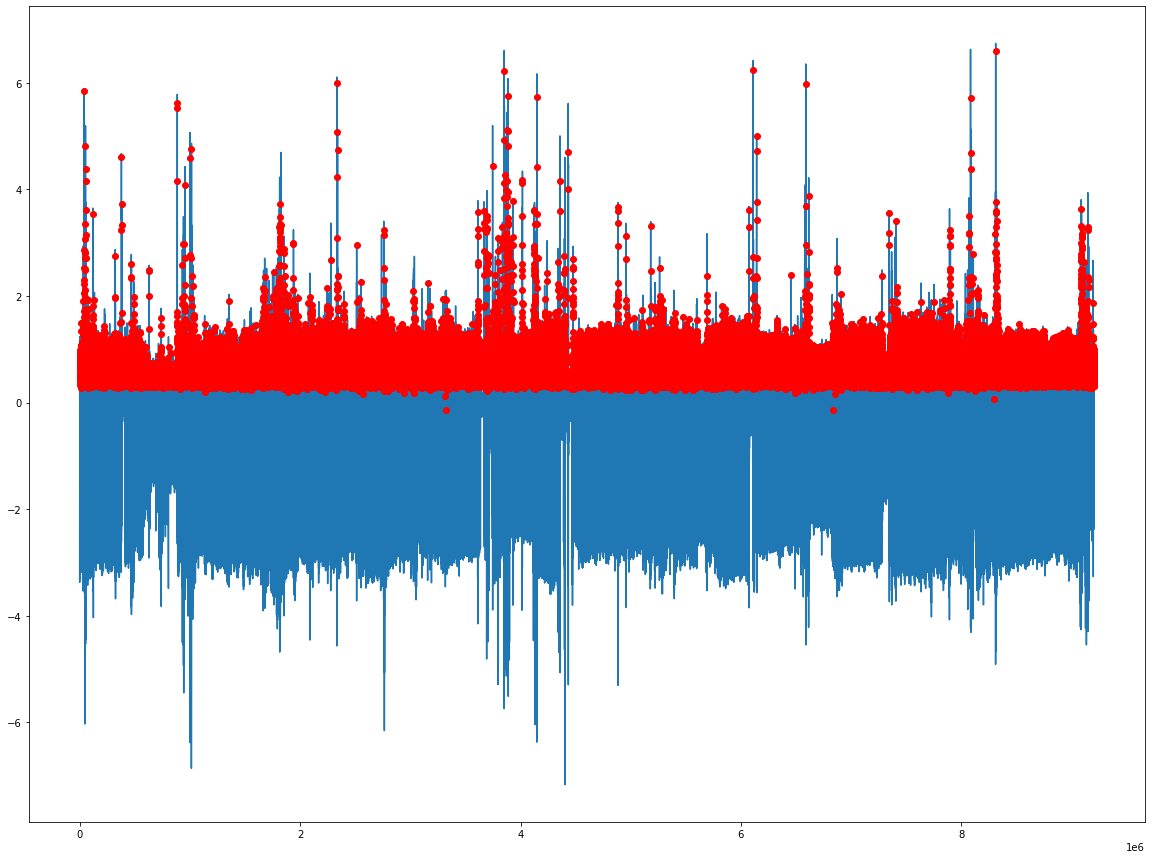

In [37]:
# plot similarity
plt.figure(figsize=(20, 15))
plt.plot(sig)
groups = np.array(group_peaks(np.array(Rpeaks), 20)).astype(int)
plt.plot(groups,sig[groups], 'ro')

In [42]:
groups_diff = np.diff(groups)

In [43]:
groups_diff = np.insert(groups_diff + groups[0],0, groups[0], axis=0 )
groups_diff

array([107, 285, 309, ..., 311, 270, 312])

In [100]:
sig_parts = []
parts = []
art_count = 0
for i in range(len(groups)):
    prev = 0 if i == 0 else groups[i-1]
    parts.append(sig[prev:groups[i]])
    
    avg = np.average(sig[prev:groups[i]])
    std = np.std(sig[prev:groups[i]])
    sigmax = np.max(sig[prev:groups[i]])
    sigmin = np.min(sig[prev:groups[i]])
    art = 1
    for j in ann.sample:
        if prev < j < groups[i]:
            art = 0
            art_count+=1
    sig_parts.append([avg, std, sigmax, sigmin, art])
print(art_count)

41


In [45]:
sig_parts = []
parts = []
art_count = 0
for i in range(100,len(sig), 100):
    sig_part = sig[i-100:i]
    avg = np.average(sig_part)
    std = np.std(sig_part)
    coef = art = 1
    for j in ann.sample:
        if i-100 < j < i:
            art = 0
            coef = 1
            art_count+=1
    sig_parts.append([avg*coef, std*coef, art])
art_count

39

In [101]:
groups.sort()

In [102]:
principalDf = pd.DataFrame(data = sig_parts, columns = ['avg', 'std', 'max', 'min',  'decision'])

In [ ]:
principalDf.plot(x ='avg', y='std', alpha=0.5, kind = 'scatter', title = "Record = "+record_number )

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_gaussian_quantiles
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [111]:
TARGET = 'decision'
data = principalDf
X = data.drop(TARGET, axis=1).to_numpy()
y = data[TARGET].to_numpy()
y

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [112]:
# Split into training and testing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

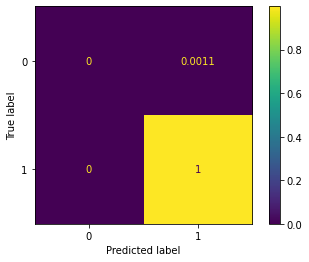

In [113]:
# Create the SVM
svm = SVC(kernel='rbf', C = 10, gamma = 1)

# Fit the data to the SVM classifier
svm = svm.fit(X_train, y_train)

# Evaluate by means of a confusion matrix
predictions = svm.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=svm.classes_)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, normalize = 'all', display_labels=svm.classes_)

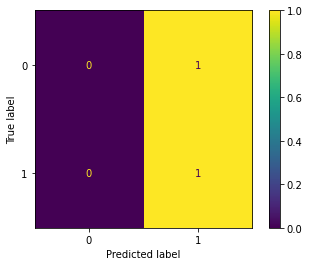

In [114]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions, normalize = 'true', display_labels=svm.classes_)

In [79]:
# Generate predictions
y_pred = svm.predict(X_test)

# Evaluate by means of accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy}')


Model accuracy: 0.9988280897863517


In [80]:
m = np.zeros((2, 2))
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i] and  y_test[i] == -1:
        m[0][0] += 1
    if y_pred[i] == y_test[i] and  y_test[i] == 1:
        m[1][1] += 1
    if y_pred[i] != y_test[i] and  y_test[i] == 1:
        m[1][0] += 1
    if y_pred[i] != y_test[i] and  y_test[i] == -1:
        m[0][1] += 1
print(m[0][0], " ", m[0][1], '\n', m[1][0], m[1][1])

0.0   0.0 
 1.0 11080.0


C:\Users\houfo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


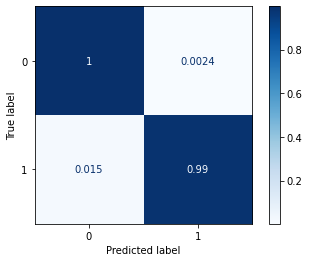

In [82]:
# Generate data
X, y = make_gaussian_quantiles(n_features=2, n_classes=2, n_samples=2500, mean=(2,3))
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create the SVM
svm = SVC(kernel='rbf', random_state = 42)

# Fit the data to the SVM classifier
svm = svm.fit(X_train, y_train)

# Evaluate by means of a confusion matrix
matrix = plot_confusion_matrix(svm, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

# Apply wavelet transofrmation and feed coefficients to the SVM

In [62]:
#!pip install PyWavelets
from pywt import wavedec

In [63]:
coeffs = wavedec(sig, 'db1', level=4)

In [64]:
sig.shape[0]

9205760

In [65]:
l = np.array_split(sig, 720)
len(l)

720

In [66]:
indexes = ann.sample/ 12786

In [67]:
indexes.astype(int)

array([  0, 144, 144, 144, 180, 181, 189, 189, 268, 269, 287, 288, 291,
       300, 304, 304, 383, 383, 540, 541, 555, 555, 556, 557, 572, 573,
       582, 582, 588, 588, 609, 610, 611, 612, 612, 612, 613, 613, 614,
       615, 617, 619])

In [68]:
coeffs = wavedec(l[0], 'sym10', level=4)

In [69]:
for i in coeffs:
    print(len(i))

816
816
1614
3210
6402


In [70]:
coeffs

[array([ 6.11969902e-01,  6.23607220e-01,  6.13756079e-01,  6.07720528e-01,
         5.36843184e-01,  6.31730272e-01,  6.15138542e-01,  5.72957715e-01,
         8.08645863e-01, -1.40563760e-01,  8.75230499e-01, -9.06806598e+00,
        -4.34737663e+00, -1.69904169e-02,  1.30931854e+00,  2.30097003e-01,
        -2.13453458e+00, -2.23774909e+00, -2.15419737e+00, -1.80597977e+00,
        -1.62230188e+00, -1.40327243e+00, -3.13601762e+00, -1.01759254e+01,
        -1.45825186e+00,  7.17433338e-01,  2.51516278e+00,  4.72425385e-01,
        -1.45675242e+00, -1.49452270e+00, -1.54443827e+00, -1.69055552e+00,
        -9.82023380e-01, -2.04552973e+00, -3.20405508e-02, -9.25008763e+00,
        -4.45615962e+00,  1.41872154e+00,  3.77730134e+00,  3.84209762e+00,
         1.38342627e+00,  9.33130237e-01,  9.79745819e-01,  8.37136856e-01,
         1.32464191e+00,  3.77610857e-01,  1.94659220e+00, -7.57893339e+00,
        -2.16222808e+00,  2.80983150e+00,  4.52440994e+00,  4.15196154e+00,
         1.6